In [8]:
import numpy as np
import scipy as sp
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt
from altair.expr import datum
alt.renderers.enable('default')
from altair_widgets import interact_with

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from datetime import datetime
from dateutil.relativedelta import relativedelta

In [20]:
df_test = pd.read_csv('ab_data.csv',parse_dates=['timestamp'], index_col='user_id')
df_test

,timestamp,group,landing_page,converted
user_id,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0
804228,2017-01-12 08:01:45.159739,control,old_page,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0
864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...
751197,2017-01-03 22:28:38.630509,control,old_page,0
945152,2017-01-12 00:51:57.078372,control,old_page,0
734608,2017-01-22 11:45:03.439544,control,old_page,0


In [45]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294478 entries, 851104 to 715931
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   timestamp     294478 non-null  datetime64[ns]
 1   group         294478 non-null  object        
 2   landing_page  294478 non-null  object        
 3   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 19.3+ MB


In [16]:
df_test.timestamp.agg([min,max])

min   2017-01-02 13:42:05.378582
max   2017-01-24 13:41:54.460509
Name: timestamp, dtype: datetime64[ns]

In [22]:
df_test.isna().sum()

timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [51]:
df_test[['group','landing_page']].value_counts()

group      landing_page
treatment  new_page        145311
control    old_page        145274
treatment  old_page          1965
control    new_page          1928
dtype: int64

In [40]:
df_test.groupby(['group','landing_page']).count()

timestamp  converted
group     landing_page                      
control   new_page           1928       1928
          old_page         145274     145274
treatment new_page         145311     145311
          old_page           1965       1965

According to the rules of the A/B test, the control group should receive only "old page", while the test group receives "new page" only. 
Since there is no additional information to determine which users are misclassified and correct them, the incorrect data is removed from the analysis.

In [54]:
df_clean = df_test.loc[(df_test.group == 'control') & (df_test.landing_page == 'old_page') | (df_test.group == 'treatment') & (df_test.landing_page == 'new_page')]

In [56]:
df_clean.groupby(['group','landing_page']).count()

,,timestamp,converted
group,landing_page,,
control,old_page,145274,145274
treatment,new_page,145311,145311


In [62]:
df_clean.index.duplicated().sum()

1

In [102]:
df_clean[df_clean.index.duplicated(keep=False)]

,timestamp,group,landing_page,converted
user_id,,,,
773192,2017-01-09 05:37:58.781806,treatment,new_page,0
773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [103]:
'''Drop out duplicate user_id  '''

df_clean.reset_index(inplace=True)
df_clean.drop_duplicates(subset=['user_id'],keep='first',inplace=True)

In [124]:
df_clean.groupby(['group','landing_page','converted']).size()

group      landing_page  converted
control    old_page      0            127785
                         1             17489
treatment  new_page      0            128046
                         1             17264
dtype: int64

<AxesSubplot:ylabel='landing_page'>

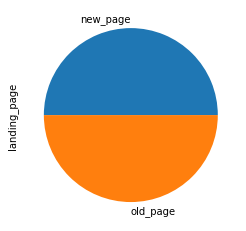

In [201]:
df_clean.landing_page.value_counts().plot.pie()

In [131]:
''' Cross table'''
pd.crosstab([df_clean.group,df_clean.landing_page],df_clean.converted,margins=True)

,converted,0,1,All
group,landing_page,,,
control,old_page,127785,17489,145274
treatment,new_page,128046,17264,145310
All,,255831,34753,290584


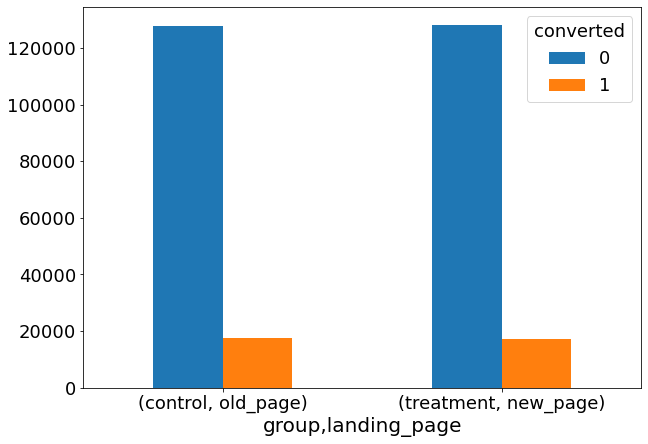

In [175]:
fig = pd.crosstab([df_clean.group,df_clean.landing_page],df_clean.converted).plot.bar(figsize=(10,7),rot=0,fontsize=18)
fig.legend(title='converted',title_fontsize=18,fontsize=18)
fig.xaxis.label.set_size(20)

In [198]:
pd.pivot_table(data=df_clean,index=['group','landing_page'],columns=['converted'],aggfunc='size',)

,converted,0,1
group,landing_page,,
control,old_page,127785,17489
treatment,new_page,128046,17264


In [113]:
df_clean.groupby('group').timestamp.agg([min,max])

,min,max
group,,
control,2017-01-02 13:42:15.234051,2017-01-24 13:41:54.460509
treatment,2017-01-02 13:42:05.378582,2017-01-24 13:41:44.097174


This shows that investigation was conducted at the same time for 2 groups as it should be. 

In [217]:
res = sp.stats.chi2_contingency(np.array(pd.crosstab([df_clean.group,df_clean.landing_page],df_clean.converted)),correction=False)

In [219]:
res

(1.7185222540121272,
 0.18988337448194853,
 1,
 array([[127899.65274757,  17374.34725243],
        [127931.34725243,  17378.65274757]]))

In [241]:
sp.stats.fisher_exact(np.array(pd.crosstab([df_clean.group,df_clean.landing_page],df_clean.converted)))

(0.9851226640350362, 0.19047706773051692)

In [238]:
crosstab = np.array(pd.crosstab([df_clean.group,df_clean.landing_page],df_clean.converted,margins=True))

[i-1 for i in list(crosstab.shape)]

[2, 2]

In [240]:
def chi2(tab):
    res = 0 
    exp = np.zeros([x - 1 for x in list(tab.shape)])
    for i in range(tab.shape[0]-1):
        for j in range(tab.shape[1]-1):
            
            exp[i,j] = tab[i,tab.shape[1]-1] * tab[tab.shape[0]-1,j] / tab[tab.shape[0]-1,tab.shape[1]-1]
            res += (tab[i,j] - exp[i,j])**2 / exp[i,j]
            
    return res, exp

            
chi2(crosstab)
    

(1.7185222540121272,
 array([[127899.65274757,  17374.34725243],
        [127931.34725243,  17378.65274757]]))